# Acceso a TIC's en hogares mexicanos

El objetivo general de este notebook es comenzar a adentrarse en la base de datos, obtener gráficas generales en  
cuanto a la Brecha de Digital de Acceso, y más ampliamente, información general de interés.

- ## Comparación de hogares con acceso a computadoras, celulares e <br> internet por estrato socioeconómico

Cómo lo dice el título, se producirá una gráfica para medir la cantidad a nivel nacional de computadoras, celulares y acceso a  
internet con el que cuentan los hogares agrupado en estratos socioeconómicos que el  propio INEGI proporciona.

### 1. Manejo de datos y creación de tabla

In [2]:
import pandas as pd #libraries
import numpy as np 
from scipy.stats import chi2_contingency

Primero cargamos la base de datos

In [3]:
path_hogar = ("../data/ENDUTIH_2021_transformed/ENDUTIH_HOGAR_2021.csv") #Dataset "hogar"
df_hogar = pd.read_csv(path_hogar) 
df_hogar.head() #show first 5 rows

,UPM,VIV_SEL,HOGAR,P4_1_1,P4_1_2,P4_1_3,P4_1_4,P4_1_5,P4_1_6,P4_1_6_1,...,P5_11_1,P5_11_2,P5_11_3,FAC_HOG,UPM_DIS,EST_DIS,DOMINIO,TLOC,ESTRATO,ENT
0,100023,1,1,1,2,2,1,2,1,1,...,3,3,3,174,1,7,U,1,3,1
1,100023,2,1,2,2,2,1,2,1,5,...,2,1,1,174,1,7,U,1,3,1
2,100023,3,1,2,1,2,1,1,1,2,...,1,1,1,174,1,7,U,1,3,1
3,100023,4,1,1,2,2,1,1,1,8,...,1,1,1,174,1,7,U,1,3,1
4,100023,5,1,2,2,2,1,2,1,3,...,2,3,3,174,1,7,U,1,3,1


Visualizamos el total de hogares en México, la cual es obtenida a través de la muestra en la variable "FAC_HOG" 

In [4]:
total_hogares = sum(df_hogar['FAC_HOG']) #total households
#df_hogar["FAC_HOG"].sum()
total_hogares #result

36616301

Elegimos variables de interés

In [5]:
df_pc_cel_hog = df_hogar[["ESTRATO", "P4_1_6", "P4_2_1", "P4_2_2", "P4_4", "FAC_HOG"]] #filter columns
df_pc_cel_hog.head() #show first 5 rows

,ESTRATO,P4_1_6,P4_2_1,P4_2_2,P4_4,FAC_HOG
0,3,1,2,1,1,174
1,3,1,2,1,1,174
2,3,1,2,1,1,174
3,3,1,2,1,1,174
4,3,1,2,1,1,174


Se cambian el nombre de las columnas para una mejor identificación de las columnas

In [6]:
df_pc_cel_hog = df_pc_cel_hog.rename(columns={"ESTRATO" : "estrato", "FAC_HOG" : "factor", "P4_1_6" : "celular", "P4_2_1" : "pc", "P4_2_2" : "portatil", "P4_4" : "internet" })
df_pc_cel_hog.head() #show first 5 rows

,estrato,celular,pc,portatil,internet,factor
0,3,1,2,1,1,174
1,3,1,2,1,1,174
2,3,1,2,1,1,174
3,3,1,2,1,1,174
4,3,1,2,1,1,174


Se identifican los valores de cada columna que pueda tener una categoría, en este caso "estrato" es el estrato socioeconómico  
al que pertenece el caso, y las demás columnas contienen datos binarios, en el que  1 es Sí y 2 es No.

In [7]:
columns_pc_cel = ["estrato", "celular", "pc", "portatil", "internet"] #catoggorical columns
for column in columns_pc_cel: 
    print(column)
    print(df_pc_cel_hog[column].value_counts())

estrato
2    30686
3    12401
1    11202
4     4996
Name: estrato, dtype: int64
celular
1    55371
2     3914
Name: celular, dtype: int64
pc
2    51336
1     7949
Name: pc, dtype: int64
portatil
2    39468
1    19817
Name: portatil, dtype: int64
internet
1    38669
2    20616
Name: internet, dtype: int64


Se reemplazan valores, no sin antes cambiar el tipo de datos de la columna "estrato"

In [8]:
df_pc_cel_hog["estrato"] = df_pc_cel_hog["estrato"].astype("object") #chage datatype
df_pc_cel_hog["estrato"].value_counts() 

2    30686
3    12401
1    11202
4     4996
Name: estrato, dtype: int64

In [9]:
print(df_pc_cel_hog["estrato"].dtypes)

object


In [10]:
df_pc_cel_hog["estrato"] = df_pc_cel_hog["estrato"].replace([1, 2, 3, 4], ["Bajo", "Medio Bajo", "Medio Alto", "Alto"]) #value substitution

In [11]:
df_pc_cel_hog["estrato"].value_counts()

Medio Bajo    30686
Medio Alto    12401
Bajo          11202
Alto           4996
Name: estrato, dtype: int64

Se reemplazan los valores negativos (2) por 0. Esto es una forma fácil de hacerlo pues cada caso que se sume representará un  
valor positivos a las preguntas. Digamos, en cada caso de que se haya contestado que sí se tiene un celular, la respuesta  
registrada dentro de los datos se resgistra con el número 1. Este puede observarse en la varriable "P4_2_1" que nombramos como  
celular, y es el caso de muchas de las variables de este DataSet

In [12]:
df_pc_cel_hog2 = df_pc_cel_hog.replace(2, 0) #replace values
for column in columns_pc_cel:
    print(column)
    print(df_pc_cel_hog2[column].value_counts())

estrato
Medio Bajo    30686
Medio Alto    12401
Bajo          11202
Alto           4996
Name: estrato, dtype: int64
celular
1    55371
0     3914
Name: celular, dtype: int64
pc
0    51336
1     7949
Name: pc, dtype: int64
portatil
0    39468
1    19817
Name: portatil, dtype: int64
internet
1    38669
0    20616
Name: internet, dtype: int64


Un pequeño vistazo a los campos agrupados, pero este no es el resultado final, pues son los datos de muestra

In [13]:
df_pc_cel_hog2.groupby("estrato").sum() #value grouping

,celular,pc,portatil,internet,factor
estrato,,,,,
Alto,4925,1495,3325,4614,3678284
Bajo,9469,334,1419,3897,6966956
Medio Alto,11980,2611,5898,10262,7784565
Medio Bajo,28997,3509,9175,19896,18186496


Antes que nada, se va a crear una nueva columna, pues "pc" y "portatil" se considerarán dentro del mismo ramo, ya que ambas  
representan una computadora, y es lo que prentende compararse en contraposición al celular.

In [14]:
df_pc = df_pc_cel_hog2[["estrato","pc", "portatil"]]
df_pc.head()

,estrato,pc,portatil
0,Medio Alto,0,1
1,Medio Alto,0,1
2,Medio Alto,0,1
3,Medio Alto,0,1
4,Medio Alto,0,1


In [15]:
df_compu = (df_pc["pc"] + df_pc["portatil"]).apply(lambda x: 1 if x >= 1 else 0) #new column from the two previous ones, if you have a pc or laptop, you are considered to have a computer.
df_compu2 = pd.concat([df_pc, df_compu], axis=1) #union of dataframe and new column
df_compu2 = df_compu2.rename(columns={0 : "computadora"}) #change column name
df_compu2.head() 

,estrato,pc,portatil,computadora
0,Medio Alto,0,1,1
1,Medio Alto,0,1,1
2,Medio Alto,0,1,1
3,Medio Alto,0,1,1
4,Medio Alto,0,1,1


In [16]:
columns_compu = ["estrato", "pc", "portatil", "computadora"]
for column in columns_compu: #count values of columns
    print(column)
    print(df_compu2[column].value_counts())

estrato
Medio Bajo    30686
Medio Alto    12401
Bajo          11202
Alto           4996
Name: estrato, dtype: int64
pc
0    51336
1     7949
Name: pc, dtype: int64
portatil
0    39468
1    19817
Name: portatil, dtype: int64
computadora
0    35946
1    23339
Name: computadora, dtype: int64


Así como en computadora, se creará una nueva columna para revisar si hay smartphones en el hogar. El dato al que se refiere la  
pregunta no revela si hay smarphones, sino que cuenta los mismo, así que se creará una nueva columna que indique si hay al menos  
un smartphone en el hogar.

In [17]:
df_smartphones = df_hogar[["P4_1_6_2"]]
df_smartphones["Smp"] = df_smartphones["P4_1_6_2"].apply(lambda x: 1 if x >= 1 <= 98 else 0)
df_smartphones.head()

/tmp/ipykernel_1344/2360942582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smartphones["Smp"] = df_smartphones["P4_1_6_2"].apply(lambda x: 1 if x >= 1 <= 98 else 0)


,P4_1_6_2,Smp
0,1,1
1,5,1
2,2,1
3,8,1
4,2,1


In [18]:
df_smartphones["Smp"].sum()

52433

Se crea un nuevo dataframe, reemplazando las columnas de pc e internet por la nueva que contiene  
ambas.

In [19]:
df_tic_hog = df_pc_cel_hog2.drop("portatil", axis=1) #drop portatil column
df_tic_hog.loc[:, "pc"] = df_compu2["computadora"] # replace pc columns by new column
df_tic_hog.loc[:,"celular"] = df_smartphones["Smp"]
df_tic_hog.head()

,estrato,celular,pc,internet,factor
0,Medio Alto,1,1,1,174
1,Medio Alto,1,1,1,174
2,Medio Alto,1,1,1,174
3,Medio Alto,1,1,1,174
4,Medio Alto,1,1,1,174


Ya que cada caso es un muestra representativa, se usa el factor de expansión para poder dar cifras totales  
respesto al total de hogares.

In [20]:
df_tic_hog[["celular", "pc", "internet"]] = df_tic_hog[["celular", "pc", "internet"]].mul(df_tic_hog["factor"], axis=0) # multiply cases by expansion factor
df_tic_hog.head()

,estrato,celular,pc,internet,factor
0,Medio Alto,174,174,174,174
1,Medio Alto,174,174,174,174
2,Medio Alto,174,174,174,174
3,Medio Alto,174,174,174,174
4,Medio Alto,174,174,174,174


Se agrupan a partir de estrato

In [21]:
df_tic_hog.groupby("estrato").sum()

,celular,pc,internet,factor
estrato,,,,
Alto,3561320,2811389,3387102,3678284
Bajo,5287349,940156,2370585,6966956
Medio Alto,7308496,4489643,6504759,7784565
Medio Bajo,16307719,6593355,12065467,18186496


Vista de los totales por campo

In [22]:
df_tic_hog.sum()

estrato     Medio AltoMedio AltoMedio AltoMedio AltoMedio ...
celular                                              32464884
pc                                                   14834543
internet                                             24327913
factor                                               36616301
dtype: object

Se ordenan para una mejor visualización

In [23]:
categoria_ord = {'Bajo': 1, 'Medio Bajo': 2, 'Medio Alto': 3, 'Alto': 4} #Dictionary order
df_tic_hog_tot = df_tic_hog.groupby("estrato").sum() #new variable of grouping dataframe
df_tic_hog_tot = df_tic_hog_tot.sort_index(key=lambda x: x.map(categoria_ord)) # order the table  
df_tic_hog_tot = df_tic_hog_tot.rename(columns={"celular" : "Smartphone", "pc" : "Computadora", "internet" : "Internet", "factor" : "Total"}) # rename total household
df_tic_hog_tot

,Smartphone,Computadora,Internet,Total
estrato,,,,
Bajo,5287349,940156,2370585,6966956
Medio Bajo,16307719,6593355,12065467,18186496
Medio Alto,7308496,4489643,6504759,7784565
Alto,3561320,2811389,3387102,3678284


Elaborando porcentajes respecto al total

In [24]:
df_tics_hog = df_tic_hog_tot.copy()
df_tics_hog[["Smartphone", "Computadora", "Internet", "Total"]] = df_tics_hog[["Smartphone", "Computadora", "Internet", "Total"]].apply(lambda x: (x / df_tics_hog["Total"]) * 100).round(2)
df_tics_hog

,Smartphone,Computadora,Internet,Total
estrato,,,,
Bajo,75.89,13.49,34.03,100.0
Medio Bajo,89.67,36.25,66.34,100.0
Medio Alto,93.88,57.67,83.56,100.0
Alto,96.82,76.43,92.08,100.0


Prueba de chi-cuadrado

In [25]:
df_chi = df_tics_hog.copy()
df_chi = df_chi.drop("Total", axis=1)
df_chi = pd.concat([df_chi, df_tic_hog_tot["Total"]], axis=1)

# Calcular los valores esperados para cada celda
df_chi['smartphone_esp'] = df_chi['Total'] * df_chi['Smartphone']
df_chi['computadora_esp'] = df_chi['Total'] * df_chi['Computadora']
df_chi['internet_esp'] = df_chi['Total'] * df_chi['Internet']

# Crear una tabla de contingencia con los valores observados
observed = df_chi[['Smartphone', 'Computadora', 'Internet']].values

# Crear una tabla de contingencia con los valores esperados
expected = df_chi[['smartphone_esp', 'computadora_esp', 'internet_esp']].values

chi2, p, dof, _ = chi2_contingency(observed, correction=False)

print(f'Estadístico de chi-cuadrado: {chi2:.4f}')
print(f'Valor p: {p:.4f}')


Estadístico de chi-cuadrado: 28.5527
Valor p: 0.0001


El valor de chi-cuadrado es mayor que el valor crítico, lo que indica que la hipótesis nula de independencia de las variables puede ser rechazada con un nivel de confianza del 99% (p < 0.01). En otras palabras, la distribución de los dispositivos electrónicos en los diferentes estratos socioeconómicos no es aleatoria y hay una asociación significativa entre ellos.

### 2. Gráficando resultados

Importar librerías de visualización

In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
#mpl.style.use('ggplot') 
import seaborn as sns

Gráfico de barras con valores absolutos

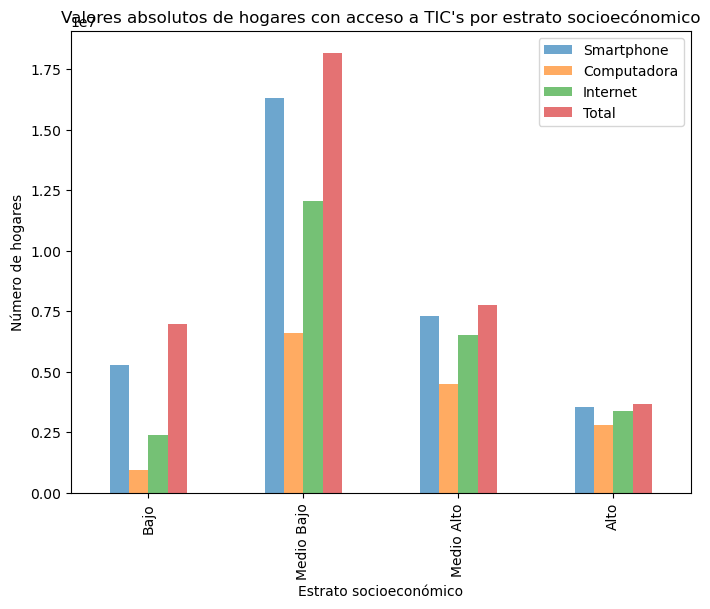

In [27]:
sns.set()
plt.rcParams.update(plt.rcParamsDefault)
df_tic_hog_tot.plot(kind="bar",
                    alpha=0.65,
                    figsize=(8,6))
plt.title("Valores absolutos de hogares con acceso a TIC's por estrato socioecónomico")
plt.ylabel("Número de hogares")
plt.xlabel("Estrato socioeconómico")
plt.show()

Gráfico de barras con valores relativos

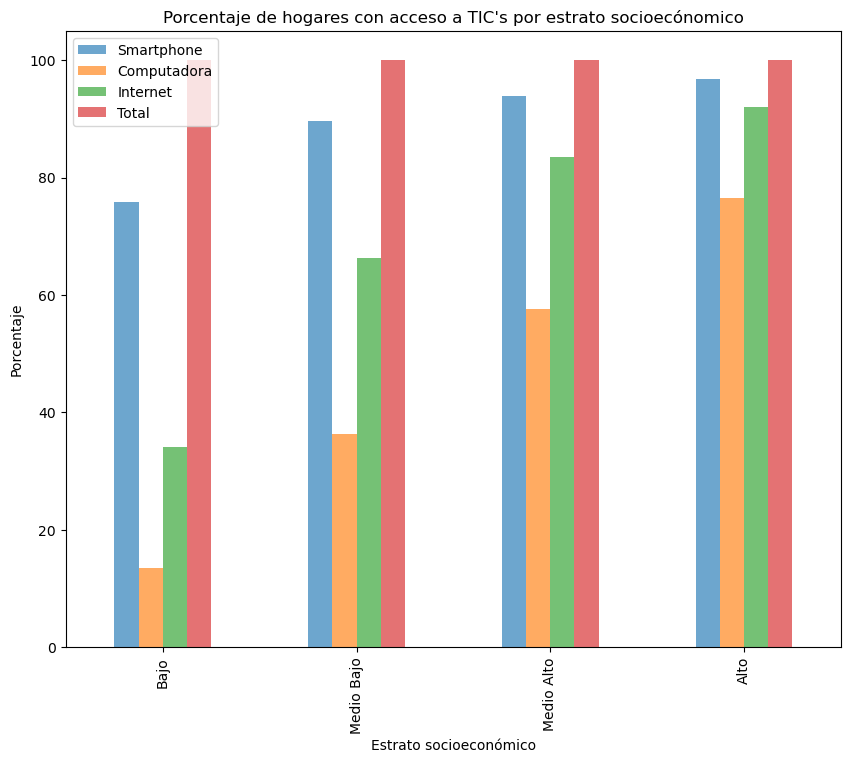

In [28]:
sns.set()
plt.rcParams.update(plt.rcParamsDefault)
df_tics_hog.plot(kind="bar",
                    alpha=0.65,
                    figsize=(10,8))
plt.title("Porcentaje de hogares con acceso a TIC's por estrato socioecónomico")
plt.ylabel("Porcentaje")
plt.xlabel("Estrato socioeconómico")
plt.show()

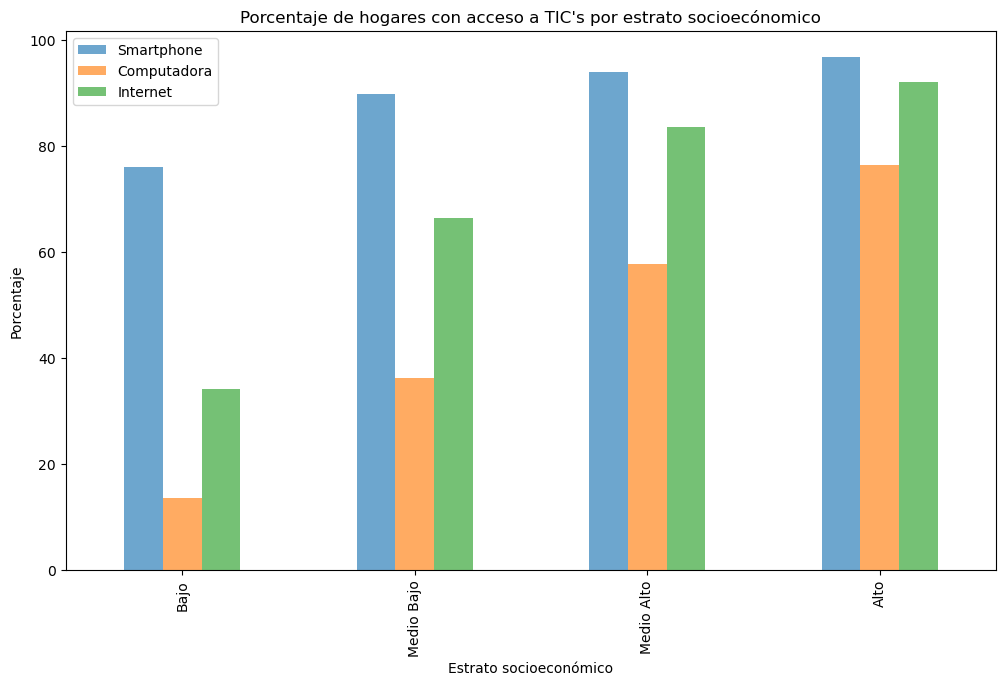

In [29]:
sns.set()
plt.rcParams.update(plt.rcParamsDefault)
df_tics = df_tics_hog.drop("Total", axis=1)

df_tics.plot(kind="bar",
             alpha=0.65,
             figsize=(12,7))
plt.title("Porcentaje de hogares con acceso a TIC's por estrato socioecónomico")
plt.ylabel("Porcentaje")
plt.xlabel("Estrato socioeconómico")
plt.show()

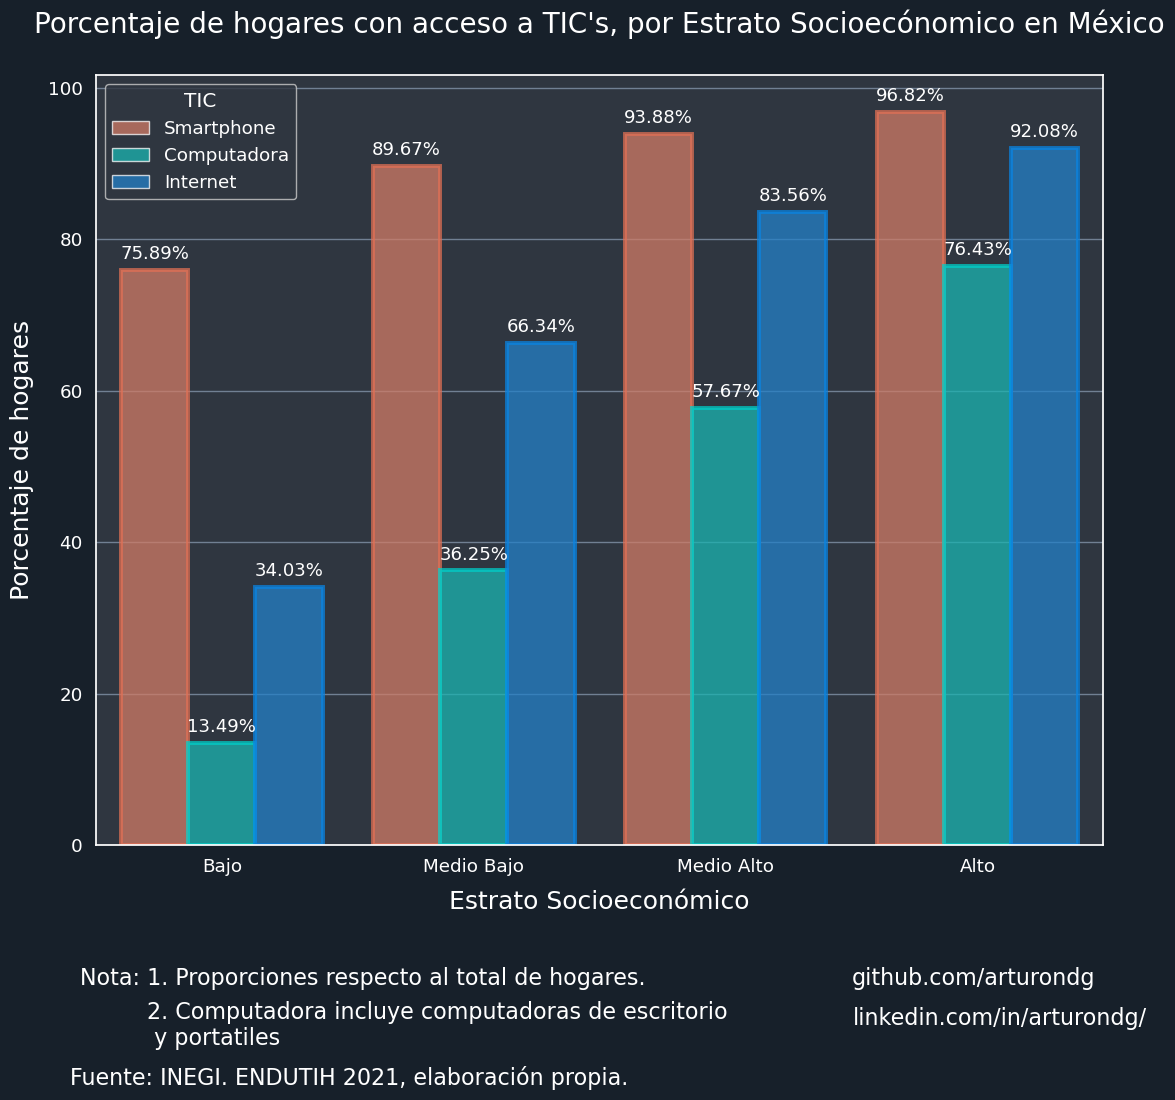

In [50]:
df_tics_sns = df_tics.copy()
df_tics_sns = pd.melt(df_tics_sns.reset_index(), id_vars=['estrato'], value_vars=['Smartphone', 'Computadora', 'Internet'], var_name='TIC', value_name='Porcentaje')
plt.figure(figsize =(13, 10))
sns.set(font_scale=1.2)
colors = ['#e17055', '#00cec9', '#0984e3'] # bar colors
colors2 = ['#e17055','#e17055','#e17055','#e17055', '#00cec9', '#00cec9','#00cec9','#00cec9','#0984e3','#0984e3','#0984e3','#0984e3'] #edge colors bar
sns.set_style({"axes.facecolor": "#2f3640", # color plotting area background
                           'axes.edgecolor': 'white', # color edge plotting area
                           'axes.labelcolor': 'white', # color text axes
                           'figure.facecolor': '#17202A', # background color of the figure area
                           'grid.color': '#718093', 
                           'xtick.color' : 'white',
                           'text.color' : 'white',
                           'xtick.color' : 'white',
                           'ytick.color' : 'white'})
ax = sns.barplot(data=df_tics_sns, x='estrato', y='Porcentaje', hue='TIC', palette=colors, alpha=0.75)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor(colors2[i % len(colors2)])
    patch.set_linewidth(2.8)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor(colors2[i % len(colors2)])
    patch.set_linewidth(2.8)
    ax.annotate(f"{patch.get_height():.2f}%", 
                xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', 
                va='bottom', 
                fontsize=13,
                color='white',
                label="Porcentaje")

ax.set_xlabel("Estrato Socioeconómico", fontsize=18, labelpad=10)
ax.set_ylabel("Porcentaje de hogares", fontsize=18, labelpad=10)
ax.set_title("Porcentaje de hogares con acceso a TIC's, por Estrato Socioecónomico en México", fontsize=20, pad=30)

plt.figtext(0.33, -0.03, "Nota: 1. Proporciones respecto al total de hogares.",
            ha="center", fontsize=16)

plt.figtext(0.164, -0.09, "2. Computadora incluye computadoras de escritorio\n y portatiles ",
            ha="left", fontsize=16)

plt.figtext(0.32, -.13, "Fuente: INEGI. ENDUTIH 2021, elaboración propia.",
            ha="center", fontsize=16)
plt.figtext(0.894, -0.03, "github.com/arturondg",
            ha="right", fontsize=16)
plt.figtext(0.82, -0.07, "linkedin.com/in/arturondg/",
            ha="center", fontsize=16)
plt.show()

- ## Porcentajes de respuesta del porqué no se cuenta con computadora<br> en casa

Está es una pregunta que está muy relacionada con los datos anteriores, pues hecha a propósito o no, hace una pregunta crucial  
respecto a esta diferencia en el acceso a las computadoras, del porque no se tiene una.

In [31]:
df_hogar.head()

,UPM,VIV_SEL,HOGAR,P4_1_1,P4_1_2,P4_1_3,P4_1_4,P4_1_5,P4_1_6,P4_1_6_1,...,P5_11_1,P5_11_2,P5_11_3,FAC_HOG,UPM_DIS,EST_DIS,DOMINIO,TLOC,ESTRATO,ENT
0,100023,1,1,1,2,2,1,2,1,1,...,3,3,3,174,1,7,U,1,3,1
1,100023,2,1,2,2,2,1,2,1,5,...,2,1,1,174,1,7,U,1,3,1
2,100023,3,1,2,1,2,1,1,1,2,...,1,1,1,174,1,7,U,1,3,1
3,100023,4,1,1,2,2,1,1,1,8,...,1,1,1,174,1,7,U,1,3,1
4,100023,5,1,2,2,2,1,2,1,3,...,2,3,3,174,1,7,U,1,3,1


Las variables que vamos utilizar son probablemnte 3, aunque por el momento se hará una gráfica general, se desglosará después  
por estratos socioeconómicos, y por comodidad se dividirán en varias.  
Además, la pregunta de "¿Por qué no disponen de computadora, laptop o tablet?" contiene opciones múltiples y una opción abierta,  
por el momento sólo se tomarán las respuestas cerradas, y se hará un posterior análisis del las respuesta abiertas si es necesario.  
Aunque por mera curiosidad primero se revisará la opción abierta. 

In [32]:
df_hogar.shape

(59285, 84)

In [33]:
df_hogar["P4_3A"].value_counts()

Desconocido                                                                      59040
NO HAY SEÑAL                                                                         5
NO HAY INTERNET                                                                      4
NO TIENEN INTERNET                                                                   4
PORQUE NO TIENEN INTERNET                                                            3
                                                                                 ...  
EL SEÑOR ES CIEGO                                                                    1
NO PUEDE MANEJAR TECNOLOGÍA POR SU ENFERMEDAD, DERRAME CEREBRAL SEGUNDO GRADO        1
SE LA LLEVARON SUS NIETOS QUE VIVÍAN AHÍ CON ELLA                                    1
SE SEPARO Y SU ESPOSA SE LAS LLEVÓ                                                   1
ACABAN DE LLEGAR A VARIOS VIVIR                                                      1
Name: P4_3A, Length: 227, dtype: int64

Hay 200 casos, en los que la respuesta fue abierta, y debido a la naturaleza específica de esta no es conveniente expandirla,  
podría quedar como un dato interesante.

In [34]:
print(df_hogar["P4_3"].value_counts()) #values of variable
print(df_hogar["P4_3"].shape) # Total cases
print(total_hogares) # total household

-1    26061
 1    18130
 2     8559
 3     4048
 4     1751
 5      387
 7      245
 6       74
 8       30
Name: P4_3, dtype: int64
(59285,)
36616301


Se eliminarár los valroes nulos, y después se reemplazarán por las etiquetas correctas

In [35]:
df_pnoc = df_hogar[["P4_3", "FAC_HOG"]] # create a new dataframe with columns of interest
df_pnoc = df_pnoc.replace(-1, np.nan) # replace -1 values with nan
df_pnoc["P4_3"].value_counts(dropna=False) # diplayin values

NaN    26061
1.0    18130
2.0     8559
3.0     4048
4.0     1751
5.0      387
7.0      245
6.0       74
8.0       30
Name: P4_3, dtype: int64

In [36]:
df_pnoco = df_pnoc.dropna() # erase nan
df_pnocom= df_pnoco.copy()
df_pnocom = df_pnocom.drop(df_pnocom[(df_pnocom["P4_3"] == 7) | (df_pnocom["P4_3"] == 8)].index)
df_pnocom["P4_3"].value_counts(dropna=False)

1.0    18130
2.0     8559
3.0     4048
4.0     1751
5.0      387
6.0       74
Name: P4_3, dtype: int64

Se guarda en una variable el total de hogares que respondió a la pregunta, y que por tanto no tiene computadore, portatil o tablet

In [37]:
Total_hog_sincomputadora = df_pnoco["FAC_HOG"].sum()
Total_hog_sincomputadora

20206514

Reemplazo de valores por etiqueta, pero primero se tiene que cambiar el tipo de datos de la columna de "int" a "object"

In [38]:
df_pnocom["P4_3"] = df_pnocom["P4_3"].astype("object") 
df_pnocom = df_pnocom.replace([1, 2, 3, 4, 5, 6], ["Falta de recursos económicos", "No les interesa o no la necesitan", "No saben usarla", "Utilizan un celular inteligente u otro dispositivo para conectarse a Internet", "Porque está descompuesta", "Por razones relacionadas con la privacidad o seguridad"])
df_pnocom["P4_3"].value_counts(dropna=False)

Falta de recursos económicos                                                     18130
No les interesa o no la necesitan                                                 8559
No saben usarla                                                                   4048
Utilizan un celular inteligente u otro dispositivo para conectarse a Internet     1751
Porque está descompuesta                                                           387
Por razones relacionadas con la privacidad o seguridad                              74
Name: P4_3, dtype: int64

In [39]:
df_nocompu_graf = df_pnocom.groupby("P4_3").sum()
df_nocompu_graf.reset_index(inplace=True)
df_nocompu_graf = df_nocompu_graf.sort_values("FAC_HOG", ascending=False)
df_nocompu_graf["FAC_HOG"]

0    11279603
1     5026407
2     2466082
5     1017601
4      224674
3       52056
Name: FAC_HOG, dtype: int64

Porcentaje del Total de hogares que respondieron a alguna de las opociones cerradas con respesto al total de hogares que no tienen computadora

In [40]:
print("Porcentaje de respuestas respecto al total", (df_pnocom["FAC_HOG"].sum() / Total_hog_sincomputadora) * 100)

Porcentaje de respuestas respecto al total 99.30670376889353


Total de hogares que respondieron a las opciones cerradas y porcenta respecto al total de hogares

In [41]:
print(df_pnocom["FAC_HOG"].sum())
print((df_pnocom["FAC_HOG"].sum() / total_hogares) * 100)

20066423
54.80188454863314


In [42]:
Total_hog_nocomputadora = df_pnocom["FAC_HOG"].sum()
df_nocompu_graf["FAC_HOG"] = ((df_nocompu_graf["FAC_HOG"] / Total_hog_nocomputadora) * 100).round(1)
df_nocompu_graf

,P4_3,FAC_HOG
0,Falta de recursos económicos,56.2
1,No les interesa o no la necesitan,25.0
2,No saben usarla,12.3
5,Utilizan un celular inteligente u otro disposi...,5.1
4,Porque está descompuesta,1.1
3,Por razones relacionadas con la privacidad o s...,0.3


In [43]:
sns.set()
plt.rcParams.update(plt.rcParamsDefault)

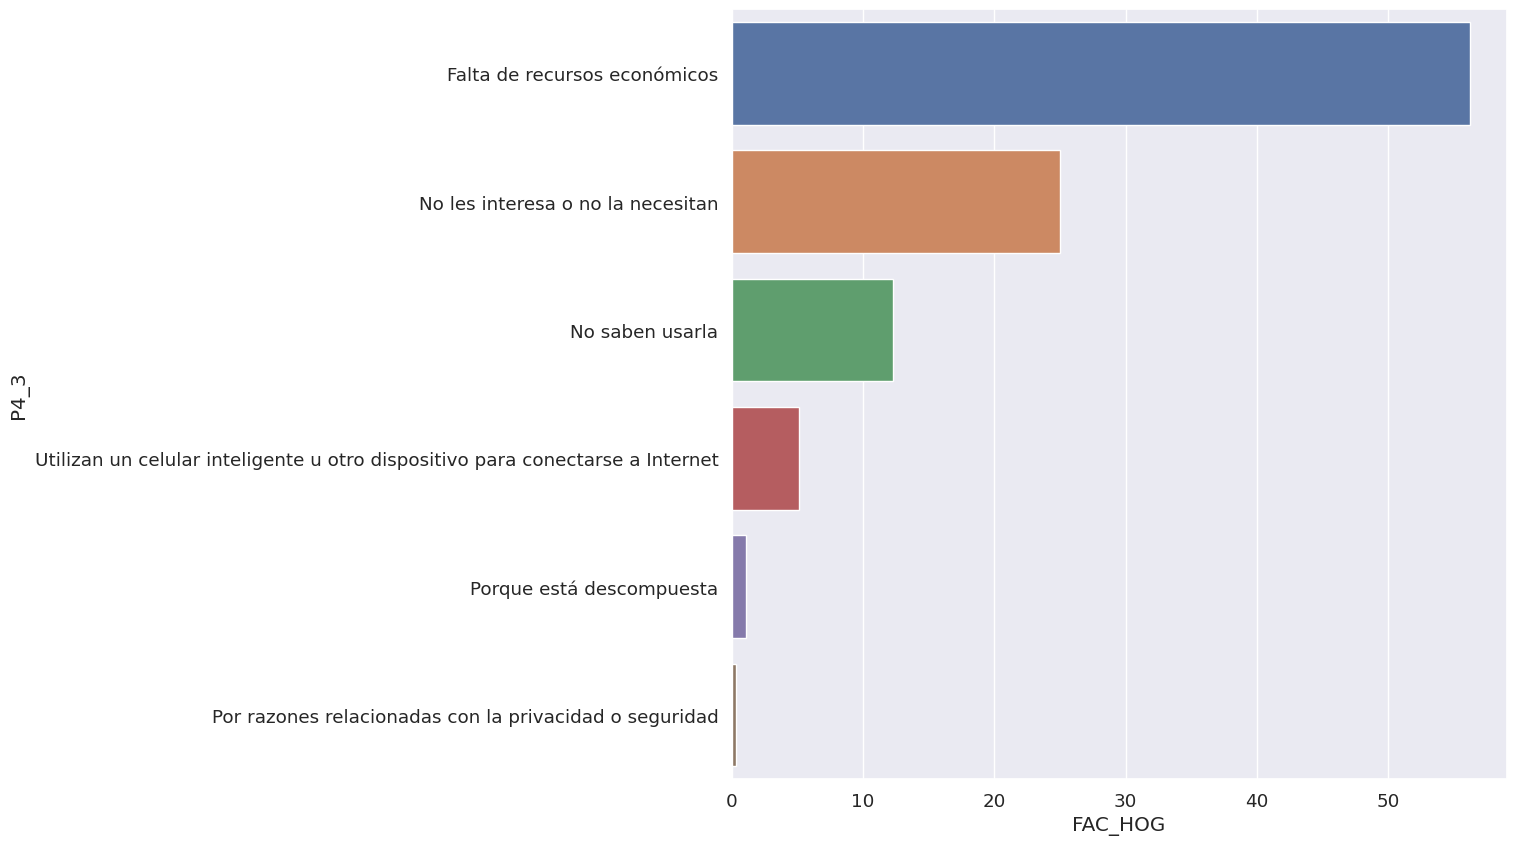

In [44]:

plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
ax = sns.barplot(data=df_nocompu_graf, y="P4_3", x="FAC_HOG")
plt.show()

In [45]:
df_nocompu_graf = df_nocompu_graf.replace(["Falta de recursos económicos", "No les interesa o no la necesitan", "No saben usarla", "Utilizan un celular inteligente u otro dispositivo para conectarse a Internet", "Porque está descompuesta", "Por razones relacionadas con la privacidad o seguridad"], ["Falta de recursos económicos", "No les interesa o no la necesitan", "No saben usarla", "Utilizan un celular inteligente u otro\n dispositivo para conectarse a Internet", "Porque está descompuesta", "Por razones relacionadas con\n la privacidad o seguridad"])
df_nocompu_graf

,P4_3,FAC_HOG
0,Falta de recursos económicos,56.2
1,No les interesa o no la necesitan,25.0
2,No saben usarla,12.3
5,Utilizan un celular inteligente u otro\n dispo...,5.1
4,Porque está descompuesta,1.1
3,Por razones relacionadas con\n la privacidad o...,0.3


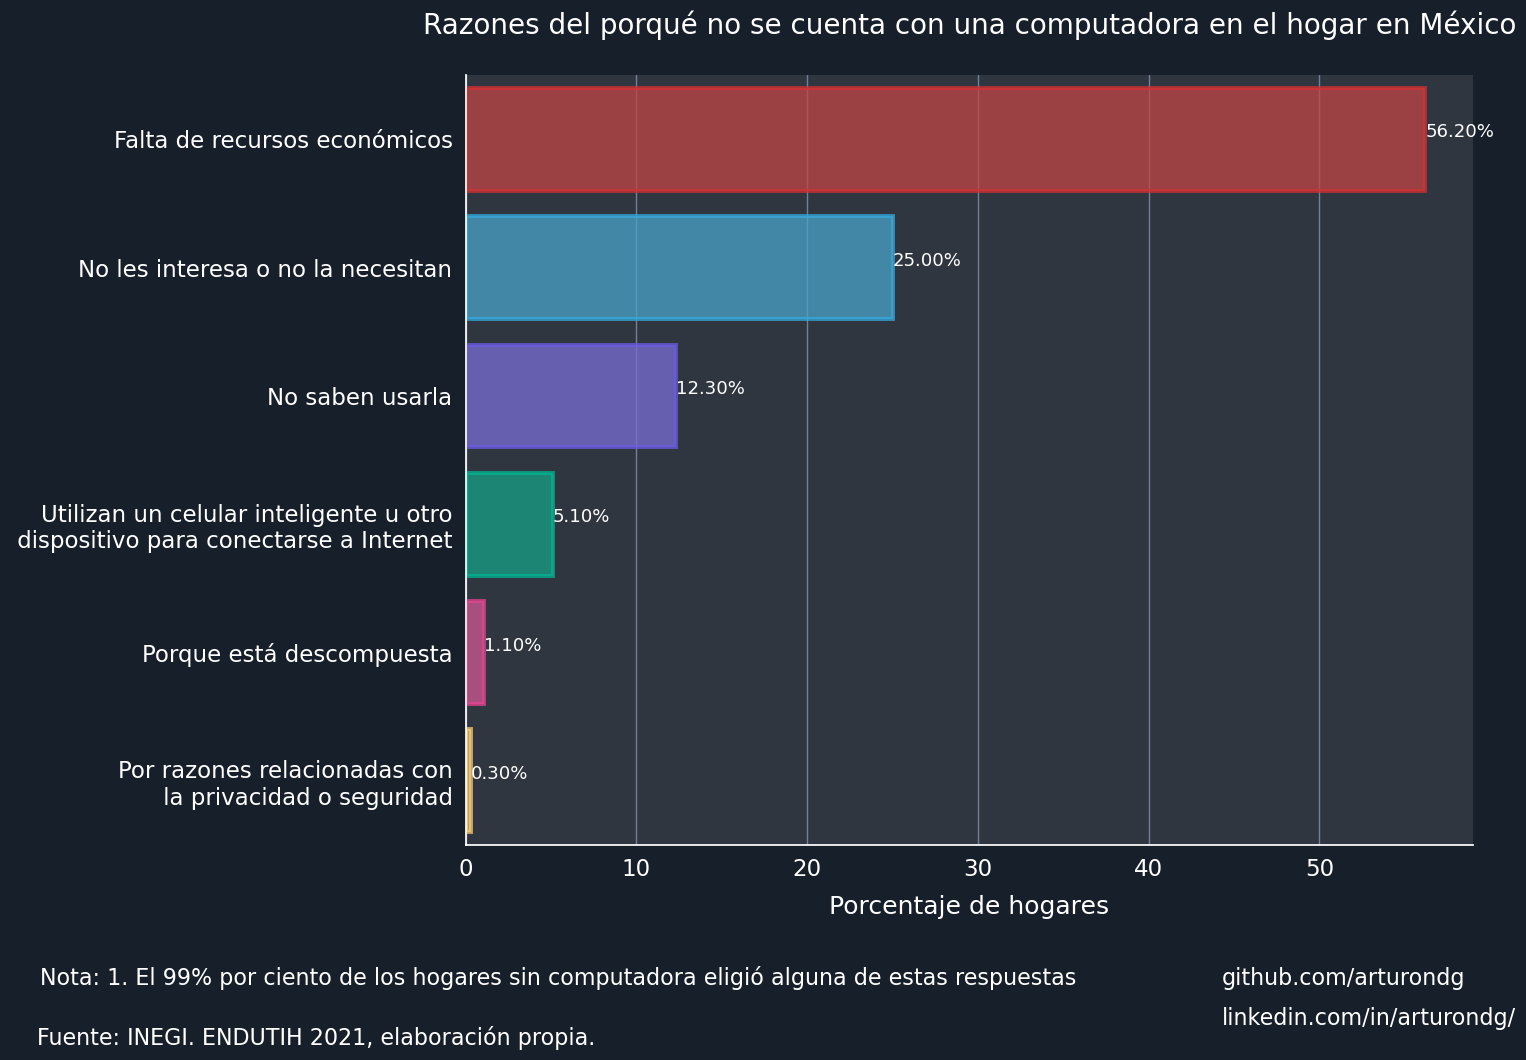

In [48]:
plt.figure(figsize=(13,10))
sns.set(font_scale=1.5)
colors = ["#d63031", "#34ace0", "#6c5ce7", "#00b894", "#e84393", "#fdcb6e"]
sns.set_style({"axes.facecolor": "#2f3640", # color plotting area background
                           'axes.edgecolor': 'white', # color edge plotting area
                           'axes.labelcolor': 'white', # color text axes
                           'figure.facecolor': '#17202A', # background color of the figure area
                           'grid.color': '#718093', 
                           'xtick.color' : 'white',
                           'text.color' : 'white',
                           'xtick.color' : 'white',
                           'ytick.color' : 'white'})

ax = sns.barplot(data=df_nocompu_graf, y="P4_3", x="FAC_HOG", palette=colors, alpha=0.75)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor(colors[i % len(colors)])
    patch.set_linewidth(2.8)

for i, patch in enumerate(ax.patches):
    ax.annotate(f"{patch.get_width():.2f}%", 
                xy=(patch.get_width(), patch.get_y() + patch.get_height() / 2), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='left', 
                va='center', 
                fontsize=13,
                color='white',
                label="FAC_HOG")
ax.set_xlabel("Porcentaje de hogares", fontsize=18, labelpad=10)
ax.set_ylabel('')
ax.set_title("Razones del porqué no se cuenta con una computadora en el hogar en México", fontsize=20, pad=30)

plt.figtext(0.196, -0.03, "Nota: 1. El 99% por ciento de los hogares sin computadora eligió alguna de estas respuestas",
            ha="center", fontsize=16)


plt.figtext(0.01, -.09, "Fuente: INEGI. ENDUTIH 2021, elaboración propia.",
            ha="center", fontsize=16)
plt.figtext(0.894, -0.03, "github.com/arturondg",
            ha="right", fontsize=16)
plt.figtext(0.82, -0.07, "linkedin.com/in/arturondg/",
            ha="center", fontsize=16)

sns.despine()
plt.show()

Gráficos en inglés

<Figure size 1300x1000 with 0 Axes>

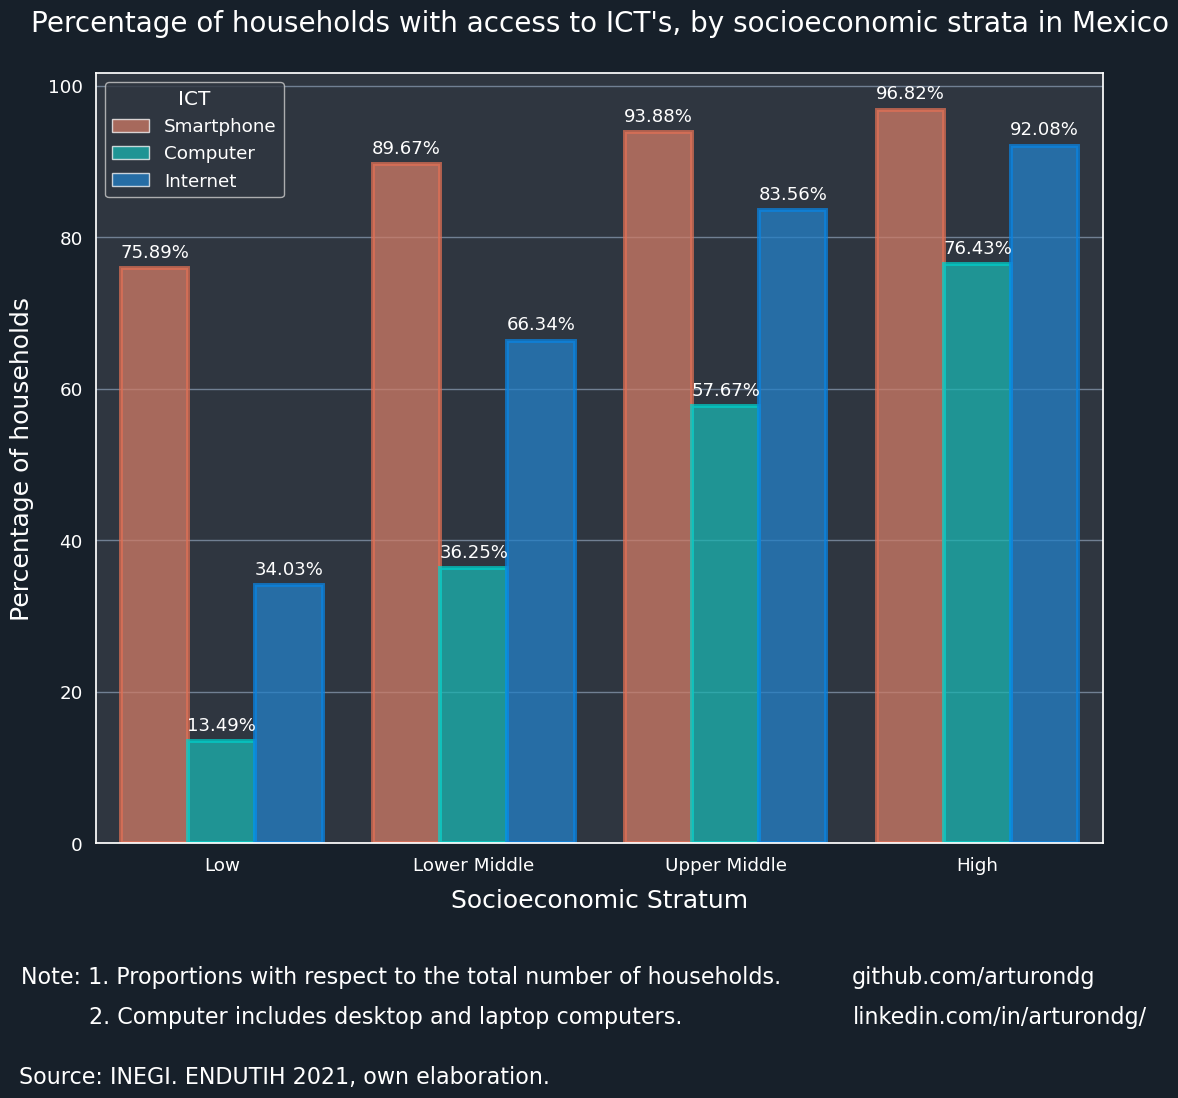

In [73]:
df_tics_sns2 = df_tics.copy()
df_tics_sns2 = df_tics_sns2.rename(columns={"Computadora" : "Computer"})


df_tics_sns2 = pd.melt(df_tics_sns2.reset_index(), id_vars=['estrato'], value_vars=['Smartphone', 'Computer', 'Internet'], var_name='ICT', value_name='Porcentaje')

df_tics_sns2["estrato"] = df_tics_sns2["estrato"].replace(["Bajo", "Medio Bajo", "Medio Alto", "Alto"], ["Low", "Lower Middle", "Upper Middle", "High"])

plt.figure(figsize =(13, 10))
sns.set(font_scale=1.2)
colors = ['#e17055', '#00cec9', '#0984e3'] # bar colors
colors2 = ['#e17055','#e17055','#e17055','#e17055', '#00cec9', '#00cec9','#00cec9','#00cec9','#0984e3','#0984e3','#0984e3','#0984e3'] #edge colors bar
sns.set_style({"axes.facecolor": "#2f3640", # color plotting area background
                           'axes.edgecolor': 'white', # color edge plotting area
                           'axes.labelcolor': 'white', # color text axes
                           'figure.facecolor': '#17202A', # background color of the figure area
                           'grid.color': '#718093', 
                           'xtick.color' : 'white',
                           'text.color' : 'white',
                           'xtick.color' : 'white',
                           'ytick.color' : 'white'})
ax = sns.barplot(data=df_tics_sns2, x='estrato', y='Porcentaje', hue='ICT', palette=colors, alpha=0.75)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor(colors2[i % len(colors2)])
    patch.set_linewidth(2.8)

for i, patch in enumerate(ax.patches):
    patch.set_edgecolor(colors2[i % len(colors2)])
    patch.set_linewidth(2.8)
    ax.annotate(f"{patch.get_height():.2f}%", 
                xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', 
                va='bottom', 
                fontsize=13,
                color='white',
                label="Porcentaje")

ax.set_xlabel("Socioeconomic Stratum", fontsize=18, labelpad=10)
ax.set_ylabel("Percentage of households", fontsize=18, labelpad=10)
ax.set_title("Percentage of households with access to ICT's, by socioeconomic strata in Mexico", fontsize=20, pad=30)

plt.figtext(0.36, -0.03, "Note: 1. Proportions with respect to the total number of households.",
            ha="center", fontsize=16)

plt.figtext(0.12, -0.07, "2. Computer includes desktop and laptop computers.",
            ha="left", fontsize=16)

plt.figtext(0.27, -.13, "Source: INEGI. ENDUTIH 2021, own elaboration.",
            ha="center", fontsize=16)
plt.figtext(0.894, -0.03, "github.com/arturondg",
            ha="right", fontsize=16)
plt.figtext(0.82, -0.07, "linkedin.com/in/arturondg/",
            ha="center", fontsize=16)
plt.show()